In [1]:
import os
os.chdir('../')

In [14]:
import json
import torch
import numpy as np
from time import sleep

from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline 

import math
import random
from collections import defaultdict
from einops.layers.torch import Rearrange

import torch
from torchvision.transforms import Compose
from torch.utils.data import DataLoader

from src.opts.opts import parser
from src.utils.reproducibility import make_reproducible
from src.models.model import VideoModel
from src.dataset.video_dataset import VideoDataset
from src.dataset.video_dataset import prepare_clips_data
from src.dataset.video_transforms import (
    IdentityTransform,
    GroupScale, 
    GroupCenterCrop, 
    GroupRandomCrop,
    GroupMultiScaleCrop,
    Stack, 
    ToTorchFormatTensor, 
    GroupNormalize, 
    GroupRandomHorizontalFlip
)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
args = parser.parse_args(args=[])
args.base_model = 'InceptionV3'
args.fusion_mode = "GSF"
args.__dict__

{'holoassist_dir': '/Users/artemmerinov/data/holoassist',
 'raw_annotation_file': '/Users/artemmerinov/data/holoassist/data-annotation-trainval-v1_1.json',
 'split_dir': '/Users/artemmerinov/data/holoassist/data-splits-v1',
 'fine_grained_actions_map_file': '/Users/artemmerinov/data/holoassist/fine_grained_actions_map.txt',
 'dataset_name': 'holoassist',
 'fusion_mode': 'GSF',
 'base_model': 'InceptionV3',
 'num_segments': 8,
 'dropout': 0.5,
 'resume': None,
 'start_epoch': 0,
 'num_epochs': 10,
 'batch_size': 16,
 'lr': 0.01,
 'momentum': 0.9,
 'weight_decay': 0.0005,
 'clip_gradient': None,
 'checkpoint_interval': 3,
 'runs_path': 'runs/',
 'num_workers': 4}

In [5]:
if args.dataset_name == 'holoassist':
    num_classes = 1887 # actions
    tr_list_file = "/Users/artemmerinov/data/holoassist/data-splits-v1.train-v1.txt"
    va_list_file = "/Users/artemmerinov/data/holoassist/data-splits-v1.val-v1.txt"
else:
    raise NotImplementedError()

In [6]:
# Fix random state to make results reproducible
make_reproducible(random_seed=0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VideoModel(
    num_classes=num_classes, 
    num_segments=args.num_segments, 
    base_model=args.base_model,
    fusion_mode=args.fusion_mode,
    dropout=args.dropout,
    verbose=False,
).to(device)
# print(model)

input_size = model.input_size
crop_size = model.crop_size
scale_size = model.scale_size
input_mean = model.input_mean
input_std = model.input_std
learnable_named_parameters = model.learnable_named_parameters

Making reproducible on seed 0
=> Using GSF fusion
No. of GSF modules = 11


# Without transform

In [7]:
tr_clip_path_to_video_arr, tr_clip_start_arr, tr_clip_end_arr, tr_clip_action_id_arr, tr_clip_mistake_arr = prepare_clips_data(
    raw_annotation_file=args.raw_annotation_file,
    holoassist_dir=args.holoassist_dir, 
    split_dir=args.split_dir,
    fine_grained_actions_map_file=args.fine_grained_actions_map_file,
    mode="train",
)

There are 7 videos in the list There are 13 videos as video files There are 0 videos that present in the list but are missing as videos.
Number of clips: 507 for mode train


In [8]:
tr_dataset = VideoDataset(
    clip_path_to_video_arr=tr_clip_path_to_video_arr,
    clip_start_arr=tr_clip_start_arr,
    clip_end_arr=tr_clip_end_arr,
    clip_label_arr=tr_clip_action_id_arr,
    num_segments=args.num_segments,
    transform=None,
    mode="train",
)

In [9]:
len(tr_dataset)

507

In [10]:
tr_dataset[338]

([<PIL.Image.Image image mode=RGB size=896x504>,
  <PIL.Image.Image image mode=RGB size=896x504>,
  <PIL.Image.Image image mode=RGB size=896x504>,
  <PIL.Image.Image image mode=RGB size=896x504>,
  <PIL.Image.Image image mode=RGB size=896x504>,
  <PIL.Image.Image image mode=RGB size=896x504>,
  <PIL.Image.Image image mode=RGB size=896x504>,
  <PIL.Image.Image image mode=RGB size=896x504>],
 1327)

In [16]:
frames, action = tr_dataset[338]

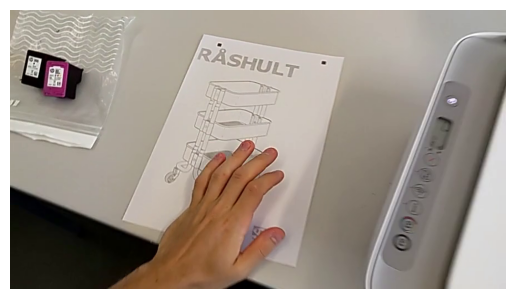

In [17]:
plt.figure()
for i in range(len(frames)):
    plt.imshow(frames[i])
    plt.axis('off')  
    plt.show()
    sleep(0.1)
    clear_output(wait=True)

# With transform

In [18]:
tr_transform = Compose([
    GroupMultiScaleCrop(crop_size, [1, .875]),
    GroupRandomHorizontalFlip(),
    Stack(roll=False),
    ToTorchFormatTensor(div=(args.base_model not in ['BNInception'])),
    # GroupNormalize(mean=input_mean, std=input_std),
])

tr_dataset = VideoDataset(
    clip_path_to_video_arr=tr_clip_path_to_video_arr,
    clip_start_arr=tr_clip_start_arr,
    clip_end_arr=tr_clip_end_arr,
    clip_label_arr=tr_clip_action_id_arr,
    num_segments=args.num_segments,
    transform=tr_transform,
    mode="train"
)

In [19]:
np_frames, action = tr_dataset[2]
print(action)

np_frames = Rearrange("(t c) h w -> t c h w", c=3, t=args.num_segments, h=input_size, w=input_size)(np_frames)
print(np_frames.shape)

2
torch.Size([8, 3, 299, 299])


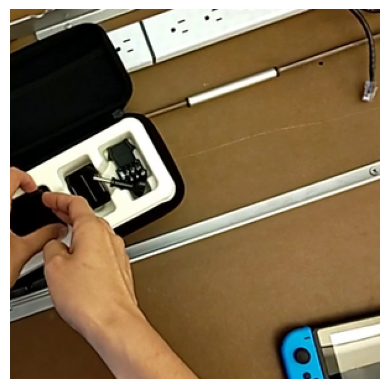

In [20]:
plt.figure()
for i in range(len(np_frames)):
    if args.base_model == "InceptionV3":
        plt.imshow(np_frames[i].permute(1, 2, 0).cpu().numpy());
    elif args.base_model == "BNInception":
        plt.imshow(np_frames[i].permute(1, 2, 0).cpu().numpy() / 255);
    plt.axis('off')  
    plt.show()
    sleep(0.1)
    clear_output(wait=True)